<a href="https://colab.research.google.com/github/NikhitapHegde/final_year_project/blob/main/Brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from tqdm import tqdm

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
from google.colab import files

# Upload the ZIP file
uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [3]:
import zipfile
import os

# Define the name of the uploaded ZIP file
zip_file_name = 'archive (1).zip'  # Change this if your file has a different name

# Extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

print("Files extracted to: extracted_files/")

Files extracted to: extracted_files/


In [4]:
dataroot ='extracted_files/brain_tumor_dataset'

workers = 2
batch_size = 64
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 2500
lr = 0.0002
beta1 = 0.5
ngpu = 1

dataloader:  <enumerate object at 0x79fc4a5a39c0>


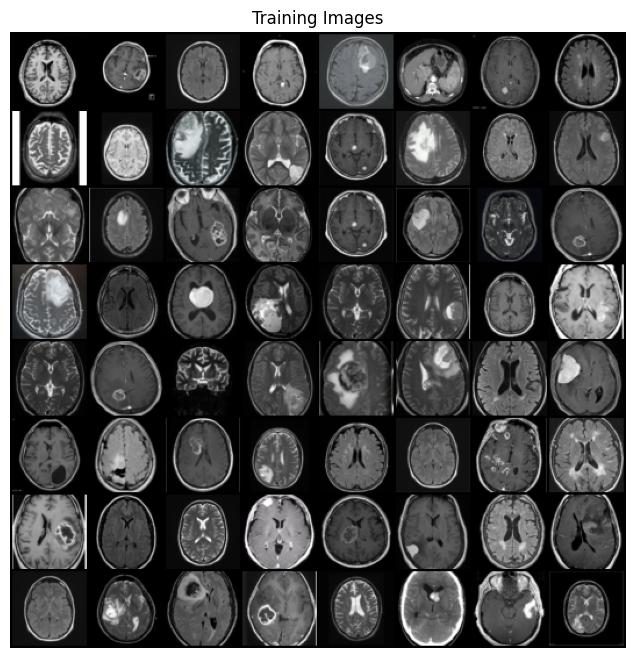

In [5]:

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
print("dataloader: ", enumerate(dataloader))

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

             nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)

In [8]:
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        iters += 1

        if iters % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (epoch == 300):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            output_path = '/extracted_files/DCGAN_results_epoch_300/'
            if not os.path.exists(output_path):
                os.makedirs(output_path)

            for i in range(64):
                vutils.save_image(fake[i], '%s/fake_samples_epoch_300_%d.png' %
                                  (output_path, i), normalize=True)

Starting Training Loop...
[12/2500][1/4]	Loss_D: 3.3382	Loss_G: 24.9813	D(x): 0.9953	D(G(z)): 0.9209 / 0.0000
[24/2500][3/4]	Loss_D: 0.3150	Loss_G: 5.1664	D(x): 0.9195	D(G(z)): 0.1547 / 0.0102
[37/2500][1/4]	Loss_D: 0.0568	Loss_G: 8.1468	D(x): 0.9659	D(G(z)): 0.0199 / 0.0004
[49/2500][3/4]	Loss_D: 0.1232	Loss_G: 11.0906	D(x): 0.9037	D(G(z)): 0.0006 / 0.0000
[62/2500][1/4]	Loss_D: 0.0353	Loss_G: 6.0127	D(x): 0.9835	D(G(z)): 0.0176 / 0.0034
[74/2500][3/4]	Loss_D: 0.1010	Loss_G: 5.5208	D(x): 0.9337	D(G(z)): 0.0223 / 0.0066
[87/2500][1/4]	Loss_D: 0.0254	Loss_G: 8.0828	D(x): 0.9982	D(G(z)): 0.0231 / 0.0007
[99/2500][3/4]	Loss_D: 0.0913	Loss_G: 6.3141	D(x): 0.9336	D(G(z)): 0.0117 / 0.0063
[112/2500][1/4]	Loss_D: 0.1098	Loss_G: 6.3650	D(x): 0.9510	D(G(z)): 0.0529 / 0.0031
[124/2500][3/4]	Loss_D: 0.3865	Loss_G: 9.2235	D(x): 0.7581	D(G(z)): 0.0003 / 0.0004
[137/2500][1/4]	Loss_D: 0.2439	Loss_G: 12.5429	D(x): 0.9831	D(G(z)): 0.1855 / 0.0001
[149/2500][3/4]	Loss_D: 0.0881	Loss_G: 5.9395	D(x): 0.9

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

# Directories
tumored_dir = 'extracted_files/brain_tumor_dataset/yes'
non_tumored_dir = 'extracted_files/brain_tumor_dataset/no'

# Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
NOISE_DIM = 100  # Dimension of the random noise vector
BATCH_SIZE = 32
EPOCHS = 5000
GENERATE_EVERY = 1000  # Generate every 100 epochs

# Load images and preprocess
def load_images_from_folder(folder, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, target_size)
            img = img_to_array(img) / 127.5 - 1  # Normalize to [-1, 1]
            images.append(img)
    return np.array(images)

# Load data
tumored_images = load_images_from_folder(tumored_dir)
non_tumored_images = load_images_from_folder(non_tumored_dir)

# Combine both classes
images = np.concatenate([tumored_images, non_tumored_images])

# Build the GAN model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=NOISE_DIM))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(np.prod((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)), activation='tanh'))
    model.add(layers.Reshape((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
    return model

def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Create the models
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Training the GAN
def train_gan():
    for epoch in range(EPOCHS):
        # Train discriminator
        idx = np.random.randint(0, images.shape[0], BATCH_SIZE)
        real_images = images[idx]
        fake_images = generator.predict(np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM)))

        real_labels = np.ones((BATCH_SIZE, 1))
        fake_labels = np.zeros((BATCH_SIZE, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM))
        g_loss = gan.train_on_batch(noise, real_labels)

        # Print progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch} | D Loss: {d_loss[0]} | G Loss: {g_loss}")

        # Generate and save images every GENERATE_EVERY epochs
        if epoch % GENERATE_EVERY == 0:
            generate_and_save_images(generator, epoch)

# Function to generate and save images
def generate_and_save_images(generator, epoch):
    noise = np.random.normal(0, 1, (1500, NOISE_DIM))
    generated_images = generator.predict(noise)

    for i in range(750):  # First 750 images for tumored
        img = (generated_images[i] + 1) * 127.5  # Rescale to [0, 255]
        img = np.clip(img, 0, 255).astype(np.uint8)
        cv2.imwrite(os.path.join(tumored_dir, f"tumored_{epoch}_{i}.png"), img)

    for i in range(750, 1500):  # Next 750 images for non-tumored
        img = (generated_images[i] + 1) * 127.5  # Rescale to [0, 255]
        img = np.clip(img, 0, 255).astype(np.uint8)
        cv2.imwrite(os.path.join(non_tumored_dir, f"non_tumored_{epoch}_{i-750}.png"), img)

# Start training the GAN
train_gan()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | D Loss: 0.7664321660995483 | G Loss: [array(0.74379814, dtype=float32), array(0.74379814, dtype=float32), array(0.21875, dtype=float32)]
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        iters += 1

        if iters % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (epoch == 300):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            output_path = 'extracted_files/DCGAN_results/'
            if not os.path.exists(output_path):
                os.makedirs(output_path)

            for i in range(64):
                vutils.save_image(fake[i], '%s/fake_samples_epoch_300_%d.png' %
                                  (output_path, i), normalize=True)

Starting Training Loop...
[12/2500][1/4]	Loss_D: 0.3600	Loss_G: 6.4696	D(x): 0.7797	D(G(z)): 0.0203 / 0.0025


KeyboardInterrupt: 

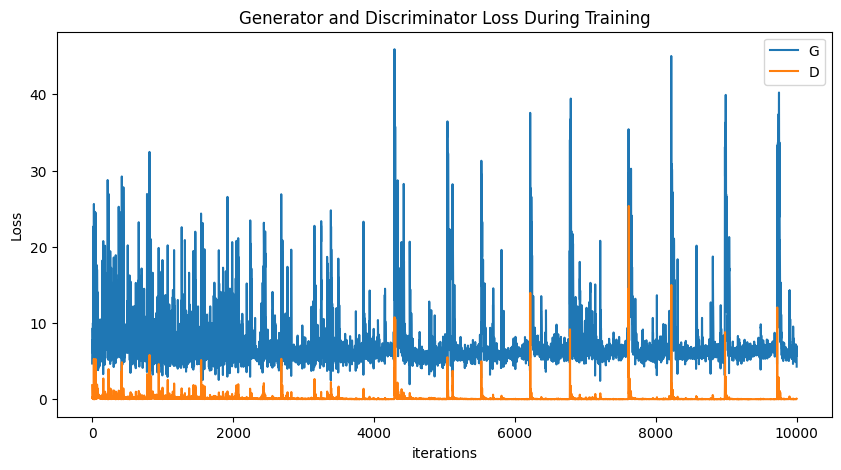

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

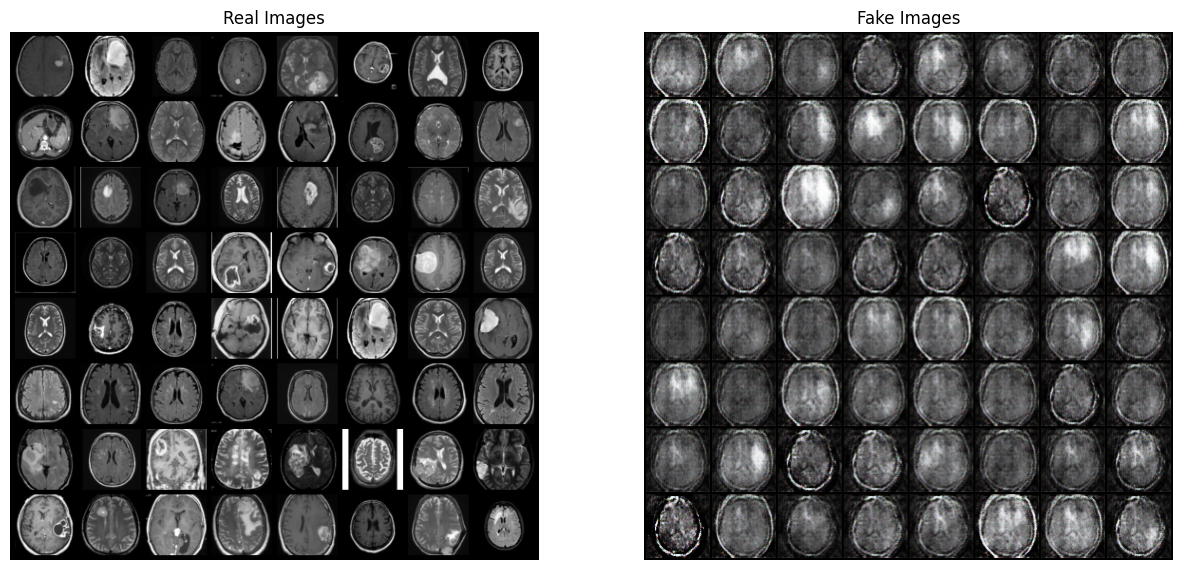

In [ ]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
import os
import torch
import torchvision.utils as vutils

# Initialize necessary variables
img_list = []
G_losses = []
D_losses = []
iters = 0

# Parameters for image generation
num_images_per_class = 1500  # Number of images per class
images_per_batch = 64        # Number of images per batch
save_frequency = num_images_per_class // images_per_batch  # Number of intervals to save images

# Output directories for labeled data (class_0 and class_1)
output_class_0_path = 'extracted_files/brain_tumor_dataset/no/'
output_class_1_path = 'extracted_files/brain_tumor_dataset/yes/'

# Create directories if they don't exist
os.makedirs(output_class_0_path, exist_ok=True)
os.makedirs(output_class_1_path, exist_ok=True)

# Assuming 'netG' is your generator model
print("Starting Training Loop...")

# Function to save generated images to the respective directories
def save_generated_images(fake, class_label, iter_num, epoch):
    if class_label == 0:
        save_path = output_class_0_path
    else:
        save_path = output_class_1_path

    for idx in range(images_per_batch):
        vutils.save_image(fake[idx], f'{save_path}/fake_sample_{iter_num + idx}_epoch_{epoch}.png', normalize=True)

# Loop to generate images for both classes
for epoch in range(num_epochs):
    for class_label in [0, 1]:  # Class 0 for non-tumor, Class 1 for tumor
        for i in range(num_images_per_class // images_per_batch):
            # Generate noise for batch
            noise = torch.randn(images_per_batch, nz, 1, 1, device=device)
            fake = netG(noise).detach().cpu()

            # Save generated images in the respective directory
            save_generated_images(fake, class_label, i * images_per_batch, epoch)

            iters += 1

            # Print progress every 50 iterations
            if iters % 50 == 0:
                print('[%d/%d][%d/%d]\tGenerated Images: %.4f\tImages saved in: %s'
                      % (epoch, num_epochs, i, num_images_per_class // images_per_batch, iters, output_class_0_path if class_label == 0 else output_class_1_path))

print(f"Training Completed. {num_images_per_class} images generated for each class. Images saved in: {output_class_0_path} and {output_class_1_path}")

Starting Training Loop...
[1/2500][3/23]	Generated Images: 50.0000	Images saved in: extracted_files/brain_tumor_dataset/no/
[2/2500][7/23]	Generated Images: 100.0000	Images saved in: extracted_files/brain_tumor_dataset/no/
[3/2500][11/23]	Generated Images: 150.0000	Images saved in: extracted_files/brain_tumor_dataset/no/
[4/2500][15/23]	Generated Images: 200.0000	Images saved in: extracted_files/brain_tumor_dataset/no/
[5/2500][19/23]	Generated Images: 250.0000	Images saved in: extracted_files/brain_tumor_dataset/no/
[6/2500][0/23]	Generated Images: 300.0000	Images saved in: extracted_files/brain_tumor_dataset/yes/
[7/2500][4/23]	Generated Images: 350.0000	Images saved in: extracted_files/brain_tumor_dataset/yes/
[8/2500][8/23]	Generated Images: 400.0000	Images saved in: extracted_files/brain_tumor_dataset/yes/
[9/2500][12/23]	Generated Images: 450.0000	Images saved in: extracted_files/brain_tumor_dataset/yes/
[10/2500][16/23]	Generated Images: 500.0000	Images saved in: extracted_files

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
from torch.utils.data import Dataset

# Custom dataset to load images (already defined earlier)
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_labels = []
        for label in ['no', 'yes']:
            class_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(class_dir):
                self.img_labels.append((os.path.join(class_dir, img_name), 0 if label == 'no' else 1))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img, label

# Dataset transformations (resize, convert to tensor)
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])

# Load the full dataset
full_dataset = BrainTumorDataset(root_dir='extracted_files/brain_tumor_dataset', transform=transform)

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# DataLoader for loading the data in batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import os

# Paths to the directories
yes_dir = 'extracted_files/brain_tumor_dataset/yes'
no_dir = 'extracted_files/brain_tumor_dataset/no'

# Function to count files in a directory
def count_files(directory):
    return len([file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))])

# Get counts
yes_count = count_files(yes_dir)
no_count = count_files(no_dir)

print(f"Number of images in 'yes' directory (tumor present): {yes_count}")
print(f"Number of images in 'no' directory (no tumor): {no_count}")


Number of images in 'yes' directory (tumor present): 1103351
Number of images in 'no' directory (no tumor): 1104098


In [ ]:
import torch.nn as nn
import torch.optim as optim

# CNN Model definition (already defined earlier)
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*32*32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model, loss function, and optimizer
model = CNN_Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Validation Loop
num_epochs = 10
best_val_acc = 0  # To store the best validation accuracy

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation after each epoch
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Validation Accuracy: {val_acc:.2f}%')

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

print('Training completed!')


KeyboardInterrupt: 

In [ ]:
import os
import torch
import torchvision.utils as vutils

# Initialize necessary variables
img_list = []
G_losses = []
D_losses = []
iters = 0

# Parameters for image generation
num_images_to_generate = 3000  # Total number of images desired
images_per_batch = 64          # Number of images per batch
save_frequency = num_images_to_generate // images_per_batch  # Number of intervals to save images

# Output directory for images
output_path = 'extracted_files/DCGAN_results/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Train Discriminator
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        iters += 1

        # Print loss and metrics every 50 iterations
        if iters % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Save generated images at defined intervals
        if iters % save_frequency == 0:
            with torch.no_grad():
                noise = torch.randn(images_per_batch, nz, 1, 1, device=device)
                fake = netG(noise).detach().cpu()
            for idx in range(images_per_batch):
                vutils.save_image(fake[idx], '%s/fake_sample_%d_iter_%d.png' %
                                  (output_path, idx + iters, epoch), normalize=True)

print(f"Training Completed. Total images generated: {num_images_to_generate}. Images saved in: {output_path}")



Starting Training Loop...
[12/2500][1/4]	Loss_D: 0.0080	Loss_G: 6.5590	D(x): 0.9964	D(G(z)): 0.0044 / 0.0022
[24/2500][3/4]	Loss_D: 0.0077	Loss_G: 9.6842	D(x): 0.9960	D(G(z)): 0.0036 / 0.0019
[37/2500][1/4]	Loss_D: 0.0651	Loss_G: 6.0983	D(x): 0.9720	D(G(z)): 0.0140 / 0.0047
[49/2500][3/4]	Loss_D: 0.0141	Loss_G: 6.8897	D(x): 0.9922	D(G(z)): 0.0061 / 0.0020
[62/2500][1/4]	Loss_D: 0.0150	Loss_G: 6.9222	D(x): 0.9885	D(G(z)): 0.0033 / 0.0017
[74/2500][3/4]	Loss_D: 0.0176	Loss_G: 6.6355	D(x): 0.9869	D(G(z)): 0.0032 / 0.0059
[87/2500][1/4]	Loss_D: 0.0277	Loss_G: 9.7541	D(x): 0.9863	D(G(z)): 0.0125 / 0.0027
[99/2500][3/4]	Loss_D: 0.0227	Loss_G: 5.7609	D(x): 0.9871	D(G(z)): 0.0085 / 0.0042
[112/2500][1/4]	Loss_D: 0.0119	Loss_G: 6.3455	D(x): 0.9964	D(G(z)): 0.0082 / 0.0028
[124/2500][3/4]	Loss_D: 0.0374	Loss_G: 5.7809	D(x): 0.9882	D(G(z)): 0.0244 / 0.0072
[137/2500][1/4]	Loss_D: 0.0119	Loss_G: 7.0484	D(x): 0.9981	D(G(z)): 0.0099 / 0.0017
[149/2500][3/4]	Loss_D: 0.0098	Loss_G: 8.6995	D(x): 0.9956

KeyboardInterrupt: 

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
data_dir = "extracted_files/DCGAN_results/"
train_dir = "extracted_files/train/"
test_dir = "extracted_files/test/"

# Example: Assume all images belong to one class ('class_0')
class_name = "class_0"

# Create train and test directories with class subdirectories
os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# List all images
all_images = [f for f in os.listdir(data_dir) if f.endswith('.png')]

# Split into train and test sets
train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)

# Move files into respective class subdirectories
for img in train_images:
    shutil.copy(os.path.join(data_dir, img), os.path.join(train_dir, class_name))

for img in test_images:
    shutil.copy(os.path.join(data_dir, img), os.path.join(test_dir, class_name))

print(f"Train images: {len(train_images)}, Test images: {len(test_images)}")


Train images: 8857, Test images: 2215


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 10
num_classes = 10  # Adjust based on your classification task

# Data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Epoch [1/10], Loss: 0.0082
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Test Accuracy: 100.00%


In [ ]:
import os
import shutil
import random

# Define source directories for the extracted data
train_dir = 'extracted_files/train/'
test_dir = 'extracted_files/test/'

# Define the destination directory (DCGAN folder structure)
output_dir = 'DCGAN_results/'

# Create the final directory structure (train, val, test, class_0, class_1)
os.makedirs(os.path.join(output_dir, 'train/class_0'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train/class_1'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val/class_0'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val/class_1'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/class_0'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/class_1'), exist_ok=True)

# Function to split and copy images
def split_and_copy(src_dir, output_dir, split_ratio=(0.7, 0.2, 0.1)):
    # Get all class directories in the source directory
    class_dirs = [d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))]

    for class_dir in class_dirs:
        class_path = os.path.join(src_dir, class_dir)
        all_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # Shuffle the files for randomness
        random.shuffle(all_files)

        # Calculate the number of files for each set based on the split ratio
        num_files = len(all_files)
        num_train = int(num_files * split_ratio[0])
        num_val = int(num_files * split_ratio[1])
        num_test = num_files - num_train - num_val  # The rest goes to the test set

        # Split the files into train, val, and test
        train_files = all_files[:num_train]
        val_files = all_files[num_train:num_train + num_val]
        test_files = all_files[num_train + num_val:]

        # Define destination paths for train, val, and test
        train_dest = os.path.join(output_dir, 'train', class_dir)
        val_dest = os.path.join(output_dir, 'val', class_dir)
        test_dest = os.path.join(output_dir, 'test', class_dir)

        # Create the directories if they don't exist
        os.makedirs(train_dest, exist_ok=True)
        os.makedirs(val_dest, exist_ok=True)
        os.makedirs(test_dest, exist_ok=True)

        # Copy files to the respective directories
        for file in train_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(train_dest, file))
        for file in val_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(val_dest, file))
        for file in test_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(test_dest, file))

# Split and copy images from both the train and test directories
split_and_copy(train_dir, output_dir)
split_and_copy(test_dir, output_dir)

print(f"Dataset has been successfully split into train, val, and test directories in {output_dir}.")


Dataset has been successfully split into train, val, and test directories in DCGAN_results/.


Found 7749 images belonging to 2 classes.
Found 2214 images belonging to 2 classes.
Found 1109 images belonging to 2 classes.


<ipython-input-40-b943efff7db9>:62: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 68s 110ms/step - accuracy: 0.9657 - loss: 0.0725 - val_accuracy: 1.0000 - val_loss: 1.2874e-04
Epoch 2/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 3.0667e-05 - val_accuracy: 1.0000 - val_loss: 9.2315e-05
Epoch 3/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 59s 87ms/step - accuracy: 1.0000 - loss: 1.0366e-04 - val_accuracy: 1.0000 - val_loss: 2.5618e-05
Epoch 4/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 7.8832e-06 - val_accuracy: 1.0000 - val_loss: 3.2209e-05
Epoch 5/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 81s 86ms/step - accuracy: 1.0000 - loss: 6.8600e-05 - val_accuracy: 1.0000 - val_loss: 8.4299e-06
Epoch 6/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 54us/step - accuracy: 1.0000 - loss: 7.9128e-06 - val_accuracy: 1.0000 - val_loss: 6.7752e-06
Epoch 7/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 1.0000 - loss: 1.9181e-05 - val_accuracy: 1.0000 - val_loss: 2.95

Test Accuracy: 100.00%


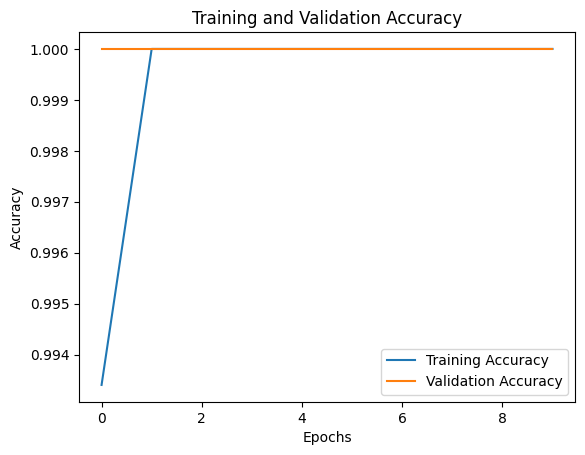

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import mixed_precision

# Set mixed precision for faster training on supported hardware (Optional)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Set up directories for training, validation, and test data
train_dir = 'DCGAN_results/train'
val_dir = 'DCGAN_results/val'
test_dir = 'DCGAN_results/test'

# Set image dimensions
img_height = 120  # Image height
img_width = 120   # Image width
batch_size = 16   # Reduced batch size for faster training

# Set up data generators with image augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Binary classification (class_0 vs class_1)
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# Use MobileNetV2 for transfer learning with pre-trained weights
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Define the model using MobileNetV2 as base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(
    loss='binary_crossentropy',  # Binary cross-entropy for binary classification
    optimizer=Adam(learning_rate=0.0001),  # Adam optimizer with a small learning rate
    metrics=['accuracy']  # Track accuracy during training
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,  # Train for 10 epochs (you can adjust this as needed)
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Optionally, save the trained model
model.save('dcgan_model.h5')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
import os

# Check if images exist in the directories
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)
test_images = os.listdir(test_dir)

print("Train Images:", train_images)
print("Validation Images:", val_images)
print("Test Images:", test_images)

# Check if they are valid image files
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']
train_images = [f for f in train_images if any(f.endswith(ext) for ext in valid_extensions)]
val_images = [f for f in val_images if any(f.endswith(ext) for ext in valid_extensions)]
test_images = [f for f in test_images if any(f.endswith(ext) for ext in valid_extensions)]

print("Valid Train Images:", train_images)
print("Valid Validation Images:", val_images)
print("Valid Test Images:", test_images)


Train Images: ['fake_sample_5520_iter_1368.png', 'fake_sample_2730_iter_666.png', 'fake_sample_4969_iter_1230.png', 'fake_sample_3993_iter_988.png', 'fake_sample_1112_iter_264.png', 'fake_sample_6919_iter_1724.png', 'fake_sample_6703_iter_1667.png', 'fake_sample_5144_iter_1276.png', 'fake_sample_1852_iter_448.png', 'fake_sample_4366_iter_1080.png', 'fake_sample_5405_iter_1345.png', 'fake_sample_4592_iter_1138.png', 'fake_sample_4649_iter_1161.png', 'fake_sample_6668_iter_1655.png', 'fake_sample_2748_iter_678.png', 'fake_sample_1668_iter_402.png', 'fake_sample_5608_iter_1391.png', 'fake_sample_7903_iter_1966.png', 'fake_sample_2586_iter_632.png', 'fake_sample_2678_iter_666.png', 'fake_sample_2861_iter_701.png', 'fake_sample_600_iter_149.png', 'fake_sample_6175_iter_1529.png', 'fake_sample_3048_iter_758.png', 'fake_sample_7570_iter_1885.png', 'fake_sample_1020_iter_252.png', 'fake_sample_7095_iter_1759.png', 'fake_sample_7370_iter_1839.png', 'fake_sample_3828_iter_954.png', 'fake_sample_

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm  # Importing tqdm for progress bar

# Directories for train, validation, and test data
train_dir = 'processed_dataset/train'
val_dir = 'processed_dataset/val'
test_dir = 'processed_dataset/test'

# Define transformations (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((64, 64)),        # Resize to a fixed size (e.g., 64x64)
    transforms.ToTensor(),              # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean=0.5 and std=0.5
])

def is_valid_file(path):
    # Check if the file is a valid image file by trying to open it with PIL
    try:
        img = Image.open(path)
        img.verify()  # Verify that it is, in fact an image
        return True
    except (IOError, SyntaxError) as e:
        print('Bad file:', path)  # Print out the names of corrupt files
        return False

# Datasets (for train, validation, and test)
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# DataLoaders (for batching the data)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)  # Adjust based on input size and layers
        self.fc2 = nn.Linear(128, 2)  # Assuming binary classification (e.g., 'class_0' and 'class_1')

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(torch.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # Number of epochs for training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Progress bar for the training loop
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for inputs, labels in pbar:
            # Move inputs and labels to the device (GPU if available)
            inputs, labels = inputs.cuda(), labels.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar description
            pbar.set_postfix(loss=running_loss/total, accuracy=100 * correct / total)

    # Print detailed accuracy for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {100 * correct / total:.2f}%")

# Validation loop with progress bar
model.eval()  # Set model to evaluation mode
val_correct = 0
val_total = 0

with torch.no_grad():  # No need to compute gradients during evaluation
    with tqdm(val_loader, desc="Validation", unit="batch") as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

# Print detailed validation accuracy
print(f"Validation Accuracy: {100 * val_correct / val_total:.2f}%")

# Testing loop with progress bar
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

# Print detailed test accuracy
print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")


FileNotFoundError: Found no valid file for the classes class_0. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp